<a href="https://colab.research.google.com/github/hsinghal11/colab/blob/main/Lab4_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets scikit-learn numpy scipy matplotlib

In [ ]:
# Import necessary libraries
from datasets import load_dataset
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import entropy
import matplotlib.pyplot as plt
import random

In [ ]:
# Load the MNIST dataset
mnist_dataset = load_dataset('mnist')

# Function to preprocess the dataset
def preprocess_data(dataset):
    images = np.array([np.array(image) for image in dataset['image']])
    labels = np.array(dataset['label'])
    images = images / 255.0  # Normalize pixel values to [0, 1]
    return images, labels

# Preprocess the training and testing datasets
train_images, train_labels = preprocess_data(mnist_dataset['train'])
test_images, test_labels = preprocess_data(mnist_dataset['test'])

# Flatten each image into a vector of 784 features
train_images = train_images.reshape(train_images.shape[0], -1)  # Shape: (60000, 784)
test_images = test_images.reshape(test_images.shape[0], -1)     # Shape: (10000, 784)

# Randomly select an initial labeled dataset of 200 samples
random.seed(42)
initial_labeled_indices = random.sample(range(train_images.shape[0]), 200)
initial_labeled_images = train_images[initial_labeled_indices]
initial_labeled_labels = train_labels[initial_labeled_indices]

# Generate the unlabeled pool
unlabeled_pool_indices = list(set(range(train_images.shape[0])) - set(initial_labeled_indices))
unlabeled_pool_images = train_images[unlabeled_pool_indices]
unlabeled_pool_labels = train_labels[unlabeled_pool_indices]  # These labels are hidden in practice

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model on the initial labeled dataset
rf_classifier.fit(initial_labeled_images, initial_labeled_labels)

# Copy the initial labeled dataset and unlabeled pool
labeled_images = initial_labeled_images.copy()
labeled_labels = initial_labeled_labels.copy()
unlabeled_images = unlabeled_pool_images.copy()
unlabeled_labels = unlabeled_pool_labels.copy()

# Active learning loop for 20 iterations
accuracies_random = []  # Store accuracies for random sampling
for iteration in range(20):
    # Randomly select a sample from the unlabeled pool
    random_index = np.random.choice(len(unlabeled_images))
    selected_image = unlabeled_images[random_index]
    selected_label = unlabeled_labels[random_index]

    # Add the selected sample to the labeled dataset
    labeled_images = np.vstack([labeled_images, selected_image])
    labeled_labels = np.append(labeled_labels, selected_label)

    # Remove the selected sample from the unlabeled pool
    unlabeled_images = np.delete(unlabeled_images, random_index, axis=0)
    unlabeled_labels = np.delete(unlabeled_labels, random_index)

    # Retrain the model
    rf_classifier.fit(labeled_images, labeled_labels)

    # Evaluate the model on the test set
    accuracy = accuracy_score(test_labels, rf_classifier.predict(test_images))
    accuracies_random.append(accuracy)  # Save accuracy
    print(f"Iteration {iteration + 1}: Accuracy = {accuracy:.4f}")

Iteration 1: Accuracy = 0.7645
Iteration 2: Accuracy = 0.7564
Iteration 3: Accuracy = 0.7542
Iteration 4: Accuracy = 0.7644
Iteration 5: Accuracy = 0.7660
Iteration 6: Accuracy = 0.7635
Iteration 7: Accuracy = 0.7641
Iteration 8: Accuracy = 0.7570
Iteration 9: Accuracy = 0.7526
Iteration 10: Accuracy = 0.7566
Iteration 11: Accuracy = 0.7665
Iteration 12: Accuracy = 0.7547
Iteration 13: Accuracy = 0.7585
Iteration 14: Accuracy = 0.7587
Iteration 15: Accuracy = 0.7691
Iteration 16: Accuracy = 0.7710
Iteration 17: Accuracy = 0.7776
Iteration 18: Accuracy = 0.7751
Iteration 19: Accuracy = 0.7733
Iteration 20: Accuracy = 0.7744


In [ ]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model on the initial labeled dataset
rf_classifier.fit(initial_labeled_images, initial_labeled_labels)

# Copy the initial labeled dataset and unlabeled pool
labeled_images = initial_labeled_images.copy()
labeled_labels = initial_labeled_labels.copy()
unlabeled_images = unlabeled_pool_images.copy()
unlabeled_labels = unlabeled_pool_labels.copy()

# Active learning loop for 20 iterations
accuracies_uncertainty = []  # Store accuracies for uncertainty sampling
for iteration in range(20):
    # Compute label probabilities for the unlabeled pool
    probabilities = rf_classifier.predict_proba(unlabeled_images)

    # Compute entropy for each sample
    entropies = entropy(probabilities, axis=1)

    # Select the sample with the highest entropy
    uncertain_index = np.argmax(entropies)
    selected_image = unlabeled_images[uncertain_index]
    selected_label = unlabeled_labels[uncertain_index]

    # Add the selected sample to the labeled dataset
    labeled_images = np.vstack([labeled_images, selected_image])
    labeled_labels = np.append(labeled_labels, selected_label)

    # Remove the selected sample from the unlabeled pool
    unlabeled_images = np.delete(unlabeled_images, uncertain_index, axis=0)
    unlabeled_labels = np.delete(unlabeled_labels, uncertain_index)

    # Retrain the model
    rf_classifier.fit(labeled_images, labeled_labels)

    # Evaluate the model on the test set
    accuracy = accuracy_score(test_labels, rf_classifier.predict(test_images))
    accuracies_uncertainty.append(accuracy)  # Save accuracy
    print(f"Iteration {iteration + 1}: Accuracy = {accuracy:.4f}")

Iteration 1: Accuracy = 0.7729
Iteration 2: Accuracy = 0.7657
Iteration 3: Accuracy = 0.7679
Iteration 4: Accuracy = 0.7769
Iteration 5: Accuracy = 0.7821
Iteration 6: Accuracy = 0.7736
Iteration 7: Accuracy = 0.7756
Iteration 8: Accuracy = 0.7738
Iteration 9: Accuracy = 0.7712
Iteration 10: Accuracy = 0.7769
Iteration 11: Accuracy = 0.7816
Iteration 12: Accuracy = 0.7714
Iteration 13: Accuracy = 0.7765
Iteration 14: Accuracy = 0.7830
Iteration 15: Accuracy = 0.7821
Iteration 16: Accuracy = 0.7803
Iteration 17: Accuracy = 0.7780
Iteration 18: Accuracy = 0.7823
Iteration 19: Accuracy = 0.7765
Iteration 20: Accuracy = 0.7794


In [ ]:
# Initialize a committee of 5 Random Forest models
committee = [RandomForestClassifier(random_state=42 + i) for i in range(5)]

# Train each model on the initial labeled dataset
for model in committee:
    model.fit(initial_labeled_images, initial_labeled_labels)

# Copy the initial labeled dataset and unlabeled pool
labeled_images = initial_labeled_images.copy()
labeled_labels = initial_labeled_labels.copy()
unlabeled_images = unlabeled_pool_images.copy()
unlabeled_labels = unlabeled_pool_labels.copy()

# Active learning loop for 20 iterations
accuracies_qbc = []  # Store accuracies for query-by-committee
for iteration in range(20):
    # Compute predictions for each unlabeled sample from all committee members
    predictions = np.array([model.predict(unlabeled_images) for model in committee])

    # Compute vote entropy for each sample
    vote_entropies = []
    for i in range(len(unlabeled_images)):
        votes = predictions[:, i]
        unique_labels, counts = np.unique(votes, return_counts=True)
        probabilities = counts / len(committee)
        vote_entropy = entropy(probabilities)
        vote_entropies.append(vote_entropy)

    # Select the sample with the highest vote entropy
    uncertain_index = np.argmax(vote_entropies)
    selected_image = unlabeled_images[uncertain_index]
    selected_label = unlabeled_labels[uncertain_index]

    # Add the selected sample to the labeled dataset
    labeled_images = np.vstack([labeled_images, selected_image])
    labeled_labels = np.append(labeled_labels, selected_label)

    # Remove the selected sample from the unlabeled pool
    unlabeled_images = np.delete(unlabeled_images, uncertain_index, axis=0)
    unlabeled_labels = np.delete(unlabeled_labels, uncertain_index)

    # Retrain all models in the committee
    for model in committee:
        model.fit(labeled_images, labeled_labels)

    # Evaluate the committee's accuracy on the test set (using the first model)
    accuracy = accuracy_score(test_labels, committee[0].predict(test_images))
    accuracies_qbc.append(accuracy)  # Save accuracy
    print(f"Iteration {iteration + 1}: Accuracy = {accuracy:.4f}")

Iteration 1: Accuracy = 0.7711
Iteration 2: Accuracy = 0.7620
Iteration 3: Accuracy = 0.7630
Iteration 4: Accuracy = 0.7626
Iteration 5: Accuracy = 0.7662
Iteration 6: Accuracy = 0.7754
Iteration 7: Accuracy = 0.7728
Iteration 8: Accuracy = 0.7696
Iteration 9: Accuracy = 0.7739
Iteration 10: Accuracy = 0.7667
Iteration 11: Accuracy = 0.7715
Iteration 12: Accuracy = 0.7671
Iteration 13: Accuracy = 0.7683
Iteration 14: Accuracy = 0.7657
Iteration 15: Accuracy = 0.7697
Iteration 16: Accuracy = 0.7816
Iteration 17: Accuracy = 0.7781
Iteration 18: Accuracy = 0.7863
Iteration 19: Accuracy = 0.7834
Iteration 20: Accuracy = 0.7904


In [ ]:
# Print final accuracies for all strategies
print(f"Final Accuracy (Random Sampling): {accuracies_random[-1]:.4f}")
print(f"Final Accuracy (Uncertainty Sampling): {accuracies_uncertainty[-1]:.4f}")
print(f"Final Accuracy (Query-by-Committee): {accuracies_qbc[-1]:.4f}")

Final Accuracy (Random Sampling): 0.7744
Final Accuracy (Uncertainty Sampling): 0.7794
Final Accuracy (Query-by-Committee): 0.7904


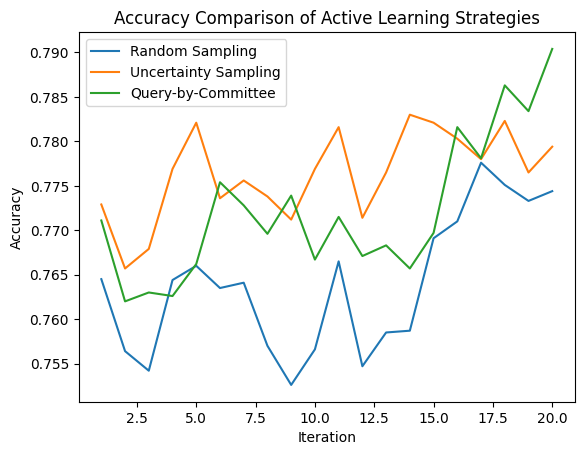

In [ ]:
# Plot the accuracies over iterations
plt.plot(range(1, 21), accuracies_random, label="Random Sampling")
plt.plot(range(1, 21), accuracies_uncertainty, label="Uncertainty Sampling")
plt.plot(range(1, 21), accuracies_qbc, label="Query-by-Committee")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Active Learning Strategies")
plt.legend()
plt.show()